## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)) <font size='3ptx'>**A benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model.**</font>

**In this post you will discover how you can estimate the importance of features for a predictive modeling problem using the XGBoost library in Python**. After reading this post you will know:
* How feature importance is calculated using the gradient boosting algorithm.
* How to plot feature importance in Python calculated by the XGBoost model.
* How to use feature importance calculated by XGBoost to perform feature selection

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sort
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance
from kutils.analysis import fiplot
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

## <font color='darkblue'>Feature Importance in Gradient Boosting</font>
**A benefit of using gradient boosting is that after the boosted trees are constructed, it is relatively straightforward to retrieve importance scores for each attribute.**

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. **The more an attribute is used to make key decisions with decision trees, the higher its relative importance.**

**This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.**

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (<font color='brown'>Gini index</font>) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

For more technical information on how feature importance is calculated in boosted decision trees, see Section 10.13.1 “Relative Importance of Predictor Variables” of the book [**The Elements of Statistical Learning: Data Mining, Inference, and Prediction**](https://amzn.to/31SA3bt), page 367.

Also, see Matthew Drury answer to the StackOverflow question “[Relative variable importance for Boosting](https://stats.stackexchange.com/questions/162162/relative-variable-importance-for-boosting)” where he provides a very detailed and practical answer.

## <font color='darkblue'>Manually Plot Feature Importance</font>
**A trained XGBoost model automatically calculates feature importance on your predictive modeling problem.**

These importance scores are available in the <font color='violet'>feature_importances_</font> member variable of the trained model. For example, they can be printed directly as follows:
```python
print(model.feature_importances_)
```

We can plot these scores on a bar chart directly to get a visual indication of the relative importance of each feature in the dataset. For example:
```python
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()
```

We can demonstrate this by training an XGBoost model on the Pima Indians onset of diabetes dataset and creating a bar chart from the calculated feature importances. Firstly, let's download the dataset and place it in your current working directory.
* [Dataset File.](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv)
* [Dataset Details.](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names)
    1. Number of times pregnant
    2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
    3. Diastolic blood pressure (mm Hg)
    4. Triceps skin fold thickness (mm)
    5. 2-Hour serum insulin (mu U/ml)
    6. Body mass index (weight in kg/(height in m)^2)
    7. Diabetes pedigree function
    8. Age (years)
    9. Class variable (0 or 1)

In [2]:
# load data
dataset = loadtxt('../../datas/pima-indians-diabetes.data.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
y = dataset[:,8]

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[0.10621197 0.2424023  0.08803366 0.07818192 0.10381887 0.1486732
 0.10059207 0.13208601]


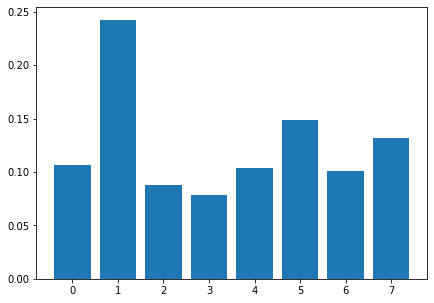

In [57]:
# fit model with training data
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
model.fit(X, y)

# feature importance
print(model.feature_importances_)

# plot
plt.rcParams['figure.figsize'] = [7, 5]
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

A downside of this plot is that the features are ordered by their input index rather than their importance. We could sort the features before plotting. Thankfully, there is a built in plot function to help us.

## <font color='darkblue'>Using theBuilt-in XGBoost Feature Importance Plot</font>
**The XGBoost library provides a built-in function to plot features ordered by their importance.**

The function is called <font color='blue'>plot_importance()</font> and can be used as follows:

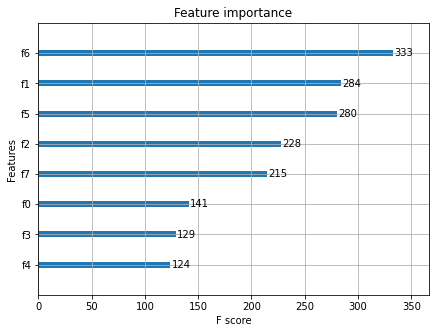

In [58]:
plot_importance(model)
pyplot.show()

You can see that features are automatically named according to their index in the input array (X) from F0 to F7.

Manually mapping these indices to names in the problem description, we can see that the plot shows F6 has the highest importance and F4 has the lowest importance. However, it is not clear enought.

Below is another example by using package [**kutils_analysis**](https://github.com/johnklee/kutils_analysis) to draw the feature importance:

In [5]:
df = pd.DataFrame(
    X, 
    columns=[
        'number_of_times_pregnant',
        'plasma_glucose',
        'diastolic_blood_pressure',
        'triceps_skin_fold_thickness',
        'serum_insulin',
        'body_mass_inde',
        'diabetes_pedigree_function',
        'age'
    ]
)

futils = fiplot.Utils(df, y)

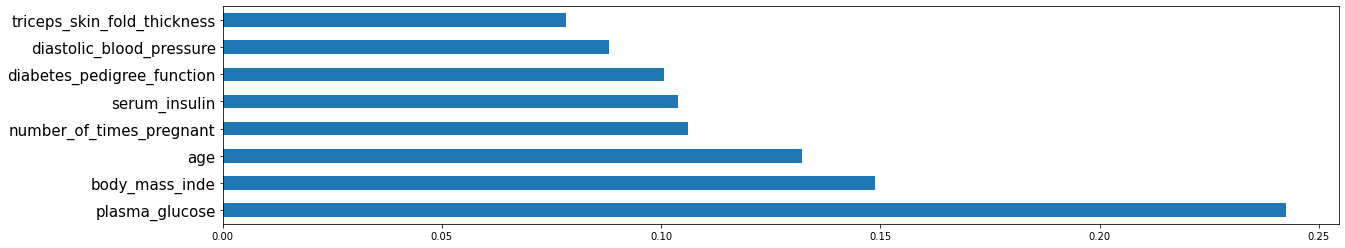

In [11]:
ax = futils.treelike_fi(model, ytick_fontsize=15)

## <font color='darkblue'>Feature Selection with XGBoost Feature Importance Scores</font>
**Feature importance scores can be used for feature selection in scikit-learn.**

This is done using the [**SelectFromModel class**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) that takes a model and can transform a dataset into a subset with selected features.

This class can take a pre-trained model, such as one trained on the entire training dataset. It can then use a threshold to decide which features to select. This threshold is used when you call the <font color='blue'>transform()</font> method on the [**SelectFromModel**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) instance to consistently select the same features on the training dataset and the test dataset.

In the example below we first train and then evaluate an XGBoost model on the entire training dataset and test datasets respectively.

Using the feature importances calculated from the training dataset, we then wrap the model in a [**SelectFromModel**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) instance. We use this to select features on the training dataset, train a model from the selected subset of features, then evaluate the model on the testset, subject to the same feature selection scheme.

For example:
```python
# select features using threshold
selection = SelectFromModel(model, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
```

For interest, we can test multiple thresholds for selecting features by feature importance. Specifically, the feature importance of each input variable, essentially allowing us to test each subset of features by importance, starting with all features and ending with a subset with the most important feature.

The complete code listing is provided below.

In [59]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# fit model with training data
model = XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[20:19:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 74.03%


c:\users\john\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


We can obtain `accuracy=74%` by training the model with all features. Let's see how feature selection can help us to improve the model:

In [52]:
model.feature_importances_

array([0.09731667, 0.23725505, 0.1002797 , 0.09353314, 0.10012697,
       0.16409664, 0.0994484 , 0.1079434 ], dtype=float32)

In [53]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
score_list = []
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)

    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    score_list.append(accuracy)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\john\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.094, n=8, Accuracy: 74.03%
[19:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.097, n=7, Accuracy: 74.68%


c:\users\john\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\john\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.099, n=6, Accuracy: 75.32%
[19:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.100, n=5, Accuracy: 72.73%


c:\users\john\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\john\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.100, n=4, Accuracy: 70.78%
[19:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.108, n=3, Accuracy: 73.38%
[19:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\john\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [54]:
score_list

[0.7402597402597403,
 0.7467532467532467,
 0.7532467532467533,
 0.7272727272727273,
 0.7077922077922078,
 0.7337662337662337,
 0.7272727272727273,
 0.7012987012987013]

In [55]:
score_df = pd.DataFrame(
    list(map(lambda t: [t[0]*100, t[1]], zip(score_list, range(8, 0, -1)))) , 
    columns=['accuracy', 'number_of_feature']
)
score_df

,accuracy,number_of_feature
0,74.025974,8
1,74.675325,7
2,75.324675,6
3,72.727273,5
4,70.779221,4
5,73.376623,3
6,72.727273,2
7,70.129870,1


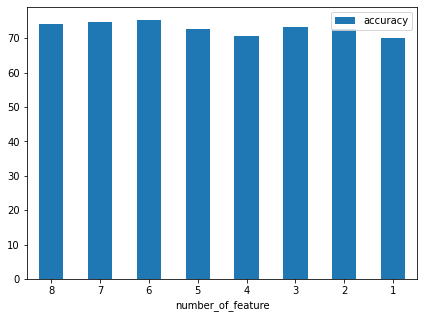

In [56]:
plt.rcParams['figure.figsize'] = [7, 5]
ax = score_df.plot.bar(x='number_of_feature', y='accuracy', rot=0)

We can see that the performance of the model generally decreases with the number of selected features.

On this problem there is a trade-off of features to test set accuracy and **we could decide to take a less complex model** (<font color='brown'>fewer attributes such as n=5</font>) **and accept a modest decrease in estimated accuracy from 74.02% down to 73.37%.**

This is likely to be a inaccurate example and less useful on such a small dataset, but may be **a more useful strategy on a larger dataset and using cross validation as the model evaluation scheme.**